# 6/24
## 데이터 로드 및 전처리

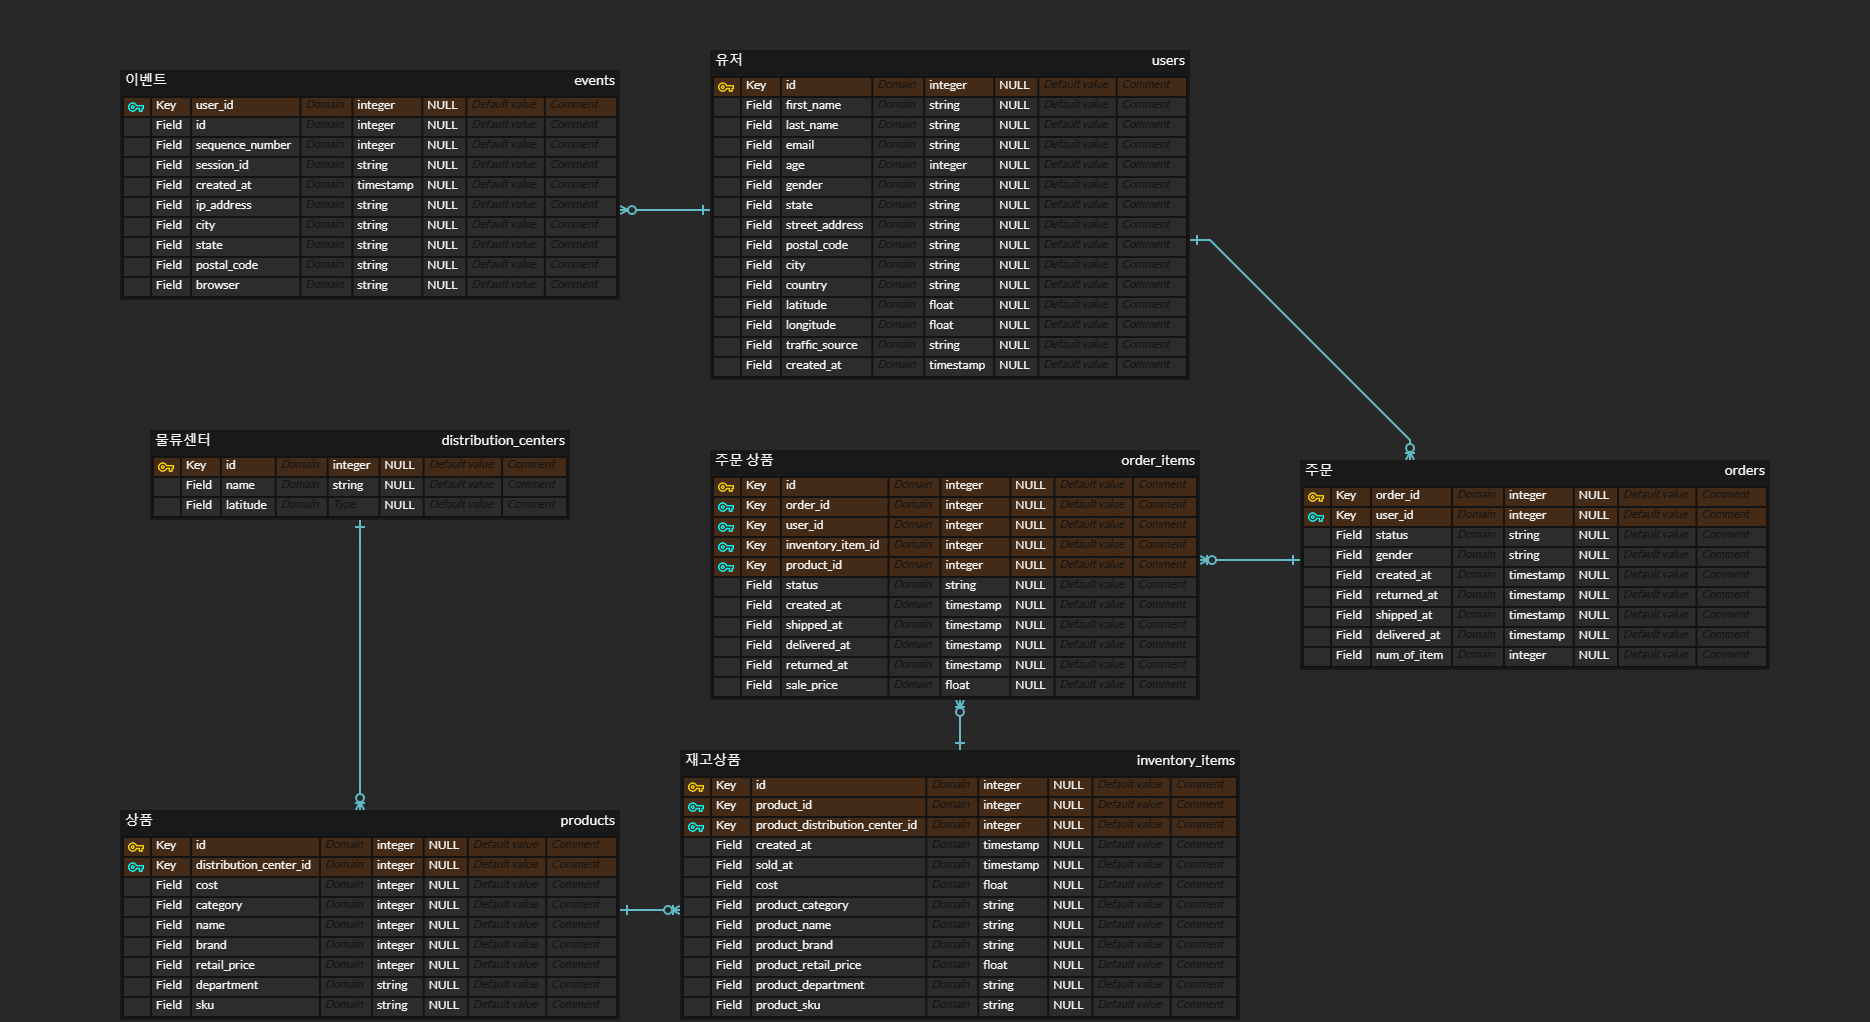

In [1]:
# 데이터 로드 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df_order = pd.read_csv('orders.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object'})
df_item = pd.read_csv('order_items.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object', 'product_id' : 'object'})

In [2]:
# df_order와 df_item merge
df_merged = pd.merge(left=df_order, right=df_item, on='order_id')
# df_merged의 중복 여부 확인
print(df_merged.size)
print(df_merged.drop_duplicates().size)
# 중복 열 없음.

3437233
3437233


In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180907 entries, 0 to 180906
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           180907 non-null  object 
 1   user_id_x          180907 non-null  object 
 2   status_x           180907 non-null  object 
 3   gender             180907 non-null  object 
 4   created_at_x       180907 non-null  object 
 5   returned_at_x      17991 non-null   object 
 6   shipped_at_x       117220 non-null  object 
 7   delivered_at_x     63061 non-null   object 
 8   num_of_item        180907 non-null  int64  
 9   id                 180907 non-null  int64  
 10  user_id_y          180907 non-null  object 
 11  product_id         180907 non-null  object 
 12  inventory_item_id  180907 non-null  int64  
 13  status_y           180907 non-null  object 
 14  created_at_y       180907 non-null  object 
 15  shipped_at_y       117220 non-null  object 
 16  de

## 2024년 3월과 5월의 매출 성장 요인

### 3월 상품 Segment

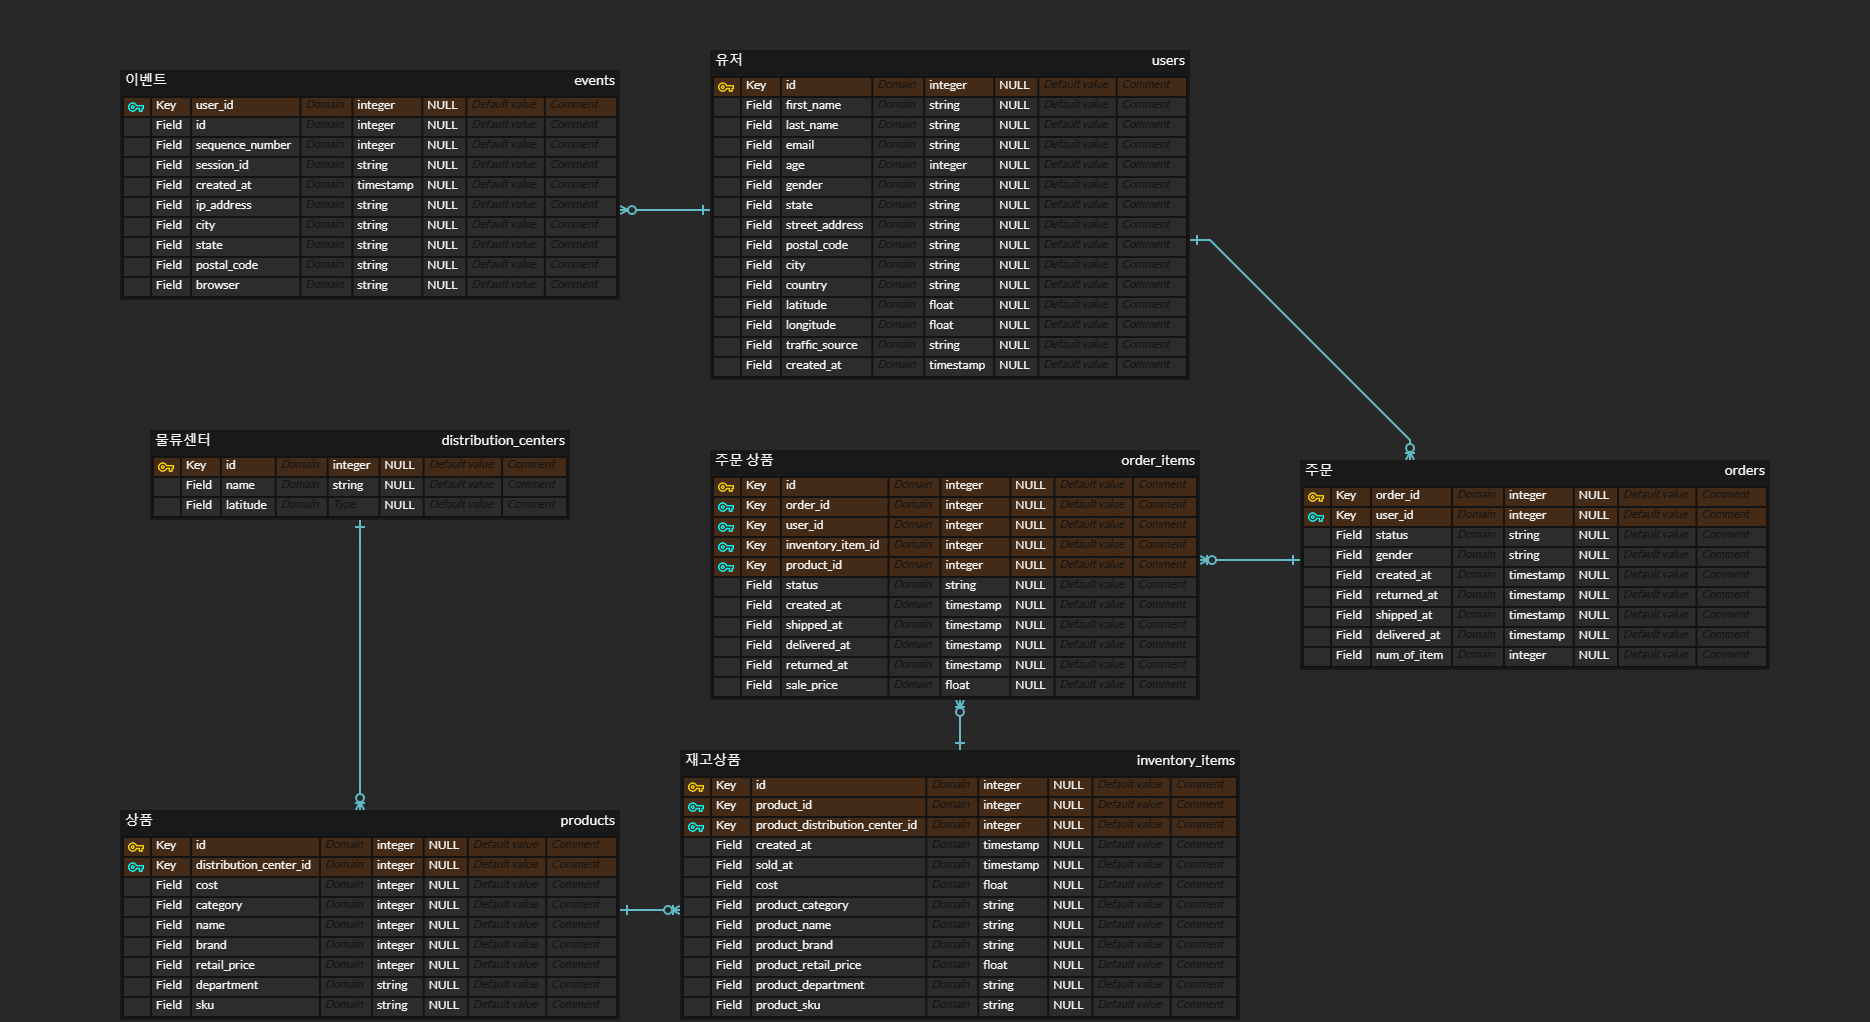

- product DB와 product_id로 JOIN이 가능하다.
- ERD 상 분석할만한 컬럼은 (cost, category, brand, retail_price, department)로 보인다.

In [4]:
df_product = pd.read_csv("products.csv", dtype={'id' : 'object'})
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  object 
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 2.0+ MB


In [5]:
df_merged = pd.merge(left = df_merged, right = df_product, left_on='product_id', right_on='id', how='left')
temp = df_merged.loc[(df_merged['created_at_x'] >= '2024-01-01') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 13707 to 180905
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                41253 non-null  object        
 1   user_id_x               41253 non-null  object        
 2   status_x                41253 non-null  object        
 3   gender                  41253 non-null  object        
 4   created_at_x            41253 non-null  object        
 5   returned_at_x           0 non-null      object        
 6   shipped_at_x            30289 non-null  object        
 7   delivered_at_x          13756 non-null  object        
 8   num_of_item             41253 non-null  int64         
 9   id_x                    41253 non-null  int64         
 10  user_id_y               41253 non-null  object        
 11  product_id              41253 non-null  object        
 12  inventory_item_id       41253 non-null  int64 

C:\Users\no1\AppData\Local\Temp\ipykernel_13756\1773095757.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])


#### brand 분석

In [6]:
# 3월 주문 데이터 조회 (주수 9 - 13)
temp1 = temp.loc[temp['week'].isin(range(9,14))].copy()
temp1['week'].unique()

<IntegerArray>
[12, 11, 9, 13, 10]
Length: 5, dtype: UInt32

In [7]:
# brand 개수
temp1['brand'].nunique()
# 구간 내 브랜드 수는 1477이다.

1477

In [8]:
df_product.loc[df_product['name'] == '180s Men\'s Foundation Glove']

id    cost         category                         name brand  \
7873   8918  8.3265  Socks & Hosiery  180s Men's Foundation Glove  180s   
7877  13720  7.8780      Accessories  180s Men's Foundation Glove  180s   
7890  28497  8.2290      Accessories  180s Men's Foundation Glove  180s   

      retail_price department                               sku  \
7873          19.5      Women  BB469043F774854635C4D72798291E9F   
7877          19.5      Women  030586FA78FC1ABDBA85DA161D943B08   
7890          19.5        Men  0704B08C67807572593DBA22B536D449   

      distribution_center_id  
7873                       3  
7877                       3  
7890                       3

In [9]:
# 브랜드와 상품의 관계
print("(중복 포함) 상품 수 : ",df_product['name'].count())
print("이름이 누락된 상품 : ",df_product['name'].isnull().sum())
print("sku 개수 : ",df_product['sku'].nunique())
print("브랜드 갯수 : ",df_product['brand'].nunique())
print("브랜드가 없는 상품 : ",df_product['brand'].isnull().sum())
print("이름과 브랜드가 같은데 다른 상품 : ",df_product.groupby(['name','brand']).size().loc[df_product.groupby(['name','brand']).size() > 1].shape[0])
print("이름은 같은데 브랜드가 다른 상품 : ",df_product.groupby('name')['brand'].nunique().loc[df_product.groupby('name')['brand'].nunique() > 1].shape[0])

(중복 포함) 상품 수 :  29118
이름이 누락된 상품 :  2
sku 개수 :  29120
브랜드 갯수 :  2756
브랜드가 없는 상품 :  24
이름과 브랜드가 같은데 다른 상품 :  1555
이름은 같은데 브랜드가 다른 상품 :  9


In [10]:
# 이름이 누락된 상품
df_product.loc[df_product['name'].isnull()]

id       cost           category name            brand  retail_price  \
3247  12586  18.972000          Intimates  NaN  Josie by Natori     36.000000   
5588  24455  67.335453  Outerwear & Coats  NaN         Tru-Spec    147.990005   

     department                               sku  distribution_center_id  
3247      Women  A7EA034186E14FB5F7B37CF664893CD2                       1  
5588        Men  B290A635641F585B3DD6B95FD42DC267                       2

In [11]:
# 브랜드가 없는 상품에 '*' 라벨링
temp1.loc[temp1['brand'].isnull(), 'brand'] = '*'

# 브랜드별 매출 분류
total_revenue = temp1['sale_price'].sum()
temp2 = temp1.groupby(['brand'])['sale_price'].sum().sort_values(ascending=False) / total_revenue
temp2 = temp2.cumsum().reset_index()
temp2['index_ratio'] = (temp2.index+1) / temp2.shape[0]
fig = px.line(temp2, x=temp2.index, y='sale_price')
# hover_data 매개변수에 인덱스를 포함하도록 설정
fig.update_traces(hovertemplate='<b>Index: %{x}</b><br>index_ratio: %{customdata[0]:.2%}<br>Cumulative Revenue Fraction: %{y:.2%}',
                  customdata=temp2[['index_ratio']])
# 그래프 출력
fig.show()
temp2
# 상위 24.5%의 브랜드(361개)가 전체 매출의 80%를 차지했다.

brand  sale_price  index_ratio
0            True Religion    0.023091     0.000677
1                   Diesel    0.043425     0.001353
2             Calvin Klein    0.062441     0.002030
3                 Carhartt    0.078633     0.002706
4        7 For All Mankind    0.094473     0.003383
...                    ...         ...          ...
1473     Alivila.Y Fashion    0.999980     0.997294
1474  Palmetto Fundraising    0.999987     0.997970
1475      Scarf_tradinginc    0.999992     0.998647
1476                  Star    0.999997     0.999323
1477             Wayfayrer    1.000000     1.000000

[1478 rows x 3 columns]

In [12]:
# 빈 그래프 객체 생성
fig = go.Figure()

for weeked in range(9, 14):
    total_revenue = temp1.groupby(['week'])['sale_price'].sum()
    temp2 = temp1.groupby(['week', 'brand'])['sale_price'].sum().unstack().fillna(0)
    temp2 = (temp2.loc[weeked].sort_values(ascending=False) / total_revenue.loc[weeked]).cumsum().reset_index(name='sale_price')
    temp2['index_ratio'] = (temp2.index + 1) / temp2.shape[0]

    # 각 주별 데이터 추가
    fig.add_trace(go.Scatter(
        x=temp2.index,
        y=temp2['sale_price'],
        mode='lines+markers',
        name=f'Week {weeked}',
        hovertemplate='<b>Index: %{x}</b><br>Index Ratio: %{customdata[0]:.2%}<br>Cumulative Revenue Fraction: %{y:.2%}',
        customdata=temp2[['index_ratio']]
    ))

# 레이아웃 설정
fig.update_layout(
    title='Cumulative Revenue by Brand Over Weeks',
    xaxis_title='Index',
    yaxis_title='Cumulative Revenue Fraction',
    hovermode='closest'
)

# 그래프 출력
fig.show()

In [13]:
# 현재 구간 [9, 13]
# 지난 15주 대비 현재 구간에서의 brand별 매출 비중
# 최근 5주가 이전 5주보다 더 반영될 수 있도록
# 15주는 5주씩 3개로 나누어 가중평균 적용함. (0.2, 0.3, 0.5)

# 지난 15주
# [46, 47, 48, 49, 50],[51, 52, 1, 2, 3],[4, 5, 6, 7, 8]


In [14]:
# 2023년의 43번째 주의 시작은 '2023-11-13'이다.
df_merged_2 = df_merged
temp = df_merged_2.loc[(df_merged_2['created_at_x'] >= '2023-11-13') & (~df_merged_2['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49070 entries, 13707 to 180906
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                49070 non-null  object        
 1   user_id_x               49070 non-null  object        
 2   status_x                49070 non-null  object        
 3   gender                  49070 non-null  object        
 4   created_at_x            49070 non-null  object        
 5   returned_at_x           0 non-null      object        
 6   shipped_at_x            36016 non-null  object        
 7   delivered_at_x          16402 non-null  object        
 8   num_of_item             49070 non-null  int64         
 9   id_x                    49070 non-null  int64         
 10  user_id_y               49070 non-null  object        
 11  product_id              49070 non-null  object        
 12  inventory_item_id       49070 non-null  int64 

C:\Users\no1\AppData\Local\Temp\ipykernel_13756\3587567280.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [15]:
# [46, 47, 48, 49, 50],[51, 52, 1, 2, 3],[4, 5, 6, 7, 8] 그룹 나누기
temp.loc[temp['brand'].isnull(), 'brand'] = '*'
temp_1 = temp.loc[temp['week'].isin([46, 47, 48, 49 ,50])]
temp_2 = temp.loc[temp['week'].isin([51, 52, 1, 2 ,3])]
temp_3 = temp.loc[temp['week'].isin([4, 5, 6, 7 ,8])]
temp_4 = temp.loc[temp['week'].isin([9, 10, 11, 12 ,13])]
print(sorted(temp_1['week'].unique()))
print(sorted(temp_2['week'].unique()))
print(sorted(temp_3['week'].unique()))
print(sorted(temp_4['week'].unique()))

[46, 47, 48, 49, 50]
[1, 2, 3, 51, 52]
[4, 5, 6, 7, 8]
[9, 10, 11, 12, 13]


In [16]:
# 누적 매출 50%에 속하는 브랜드 추출
values = 0.5
brand_index = (temp_4.groupby(['brand'])['sale_price'].sum() / temp_4['sale_price'].sum()).loc[(temp_4.groupby(['brand'])['sale_price'].sum() / temp_4['sale_price'].sum()).sort_values(ascending=False).cumsum() < values].sort_values(ascending=False).cumsum().index

# brand별 전체 매출 대비 비중 구하기
ratio_1 = temp_1.groupby(['brand'])['sale_price'].sum() / temp_1['sale_price'].sum()
ratio_2 = temp_2.groupby(['brand'])['sale_price'].sum() / temp_2['sale_price'].sum()
ratio_3 = temp_3.groupby(['brand'])['sale_price'].sum() / temp_3['sale_price'].sum()
ratio_4 = temp_4.groupby(['brand'])['sale_price'].sum() / temp_4['sale_price'].sum()
temp_concat = pd.concat([ratio_1,ratio_2,ratio_3,ratio_4],axis=1).fillna(0)
temp_concat.columns = ['1_group', '2_group', '3_group', '4_group']
temp_concat['123_avg'] = (temp_concat['1_group'] * 0.2 + temp_concat['2_group'] * 0.3 + temp_concat['3_group'] * 0.5)
fig = px.scatter(temp_concat[['4_group','123_avg']], x='4_group', y='123_avg', color=(temp_concat.index.isin(brand_index)), hover_data={'브랜드': temp_concat.index}, opacity=0.7)
# y=x 선 추가
fig.add_trace(go.Scatter(
    x=[0, max(temp_concat['4_group'].max(), temp_concat['123_avg'].max())],
    y=[0, max(temp_concat['4_group'].max(), temp_concat['123_avg'].max())],
    mode='lines',
    name='y=x',
    line=dict(color='black', dash='dash')
))

# 레이아웃 업데이트
fig.update_layout(title='지난 15주 대비 [9, 13] 구간 내 매출 비중')

# 그래프 출력
fig.show()

# 브랜드별 지난 15주의 매출 비중과 [9, 13] 구간 내 매출 비중을 비교한 시각화이다.
# y=x에 가까울수록 지난 15주의 매출 비중에서 크게 벗어나지 않았다는 의미이다.
# x가 y보다 크면, 구간 내 매출 비중이 지난 15주 매출 비중을 통해 예측한 비중보다 더 컸다는 의미이다.
# x가 y보다 작으면, 예측한 비중보다 매출 비중이 실제로 더 작아졌다는 의미이다.
# 그러므로, y=x에 가까우면, 전체 매출 성장에 크게 영향을 주지 않았다는 것이다.
# x > y이면, 전체 매출 성장에 긍정적인 영향을 주었다는 것이다.
# x < y이면, 전체 매출 성장에 부정적인 영향을 주었다는 것이다.

In [17]:
# brand를 n그룹으로 나누어 예상 매출 성장률과 실제 성장률을 비교하여 시각화하기

exp_growth = (temp_4['sale_price'].sum() / (temp_1['sale_price'].sum() * 0.2 + temp_2['sale_price'].sum() * 0.3 + temp_3['sale_price'].sum() * 0.5))
temp_5 = pd.concat([temp_1.groupby(['brand'])['sale_price'].sum(), temp_2.groupby(['brand'])['sale_price'].sum(), temp_3.groupby(['brand'])['sale_price'].sum()], axis=1).fillna(0)
temp_5.columns = ['week_1','week_2','week_3']
temp_5['week_avg'] = (temp_5['week_1'] * 0.2 + temp_5['week_2'] * 0.3 + temp_5['week_3'] * 0.5) * exp_growth
temp_5 = temp_5.drop(columns = ['week_1','week_2','week_3'])
temp_5 = pd.concat([temp_5, temp_4.groupby(['brand'])['sale_price'].sum()], axis=1).fillna(0)
temp_5.columns = ['week_avg', 'group_4']


# 'week_avg' 열을 누적 밀도에 따라 n개의 그룹으로 나누기
n = 10  # 그룹의 수
sorted_values = temp_5['group_4'].sort_values(ascending=False)
cumulative_density = (sorted_values / sorted_values.sum()).cumsum()

# n개의 그룹으로 나누기
groups = []
for i in range(1, n+1):
    threshold = i / n  # 누적 밀도의 기준값
    group_index = cumulative_density[(cumulative_density <= threshold) & (cumulative_density > (threshold - (1 / n )))].index
    groups.append(group_index)
    
temp_6 = pd.concat([temp_5.loc[temp_5.index.isin(index)].sum() for index in groups], axis=1).T
group_labels = [f'{start:.0f}-{end:.0f}%' for start, end in zip(range(0, 100, int(100/n)), range(int(100/n), 100 + int(100/n), int(100/n)))]
temp_6.index = group_labels[:n]
temp_6['diff'] = temp_6['group_4'] - temp_6['week_avg']
fig = px.scatter(temp_6, x='week_avg', y='group_4', color=temp_6.index, opacity=0.7,
                 hover_data={'diff': True})
# y=x 선 추가
fig.add_trace(go.Scatter(
    x=[min(temp_6['group_4'].min(), temp_6['week_avg'].min()), max(temp_6['group_4'].max(), temp_6['week_avg'].max())],
    y=[min(temp_6['group_4'].min(), temp_6['week_avg'].min()), max(temp_6['group_4'].max(), temp_6['week_avg'].max())],
    mode='lines',
    name='y=x',
    line=dict(color='black', dash='dash')
))

# 레이아웃 업데이트
fig.update_layout(title='지난 15주 대비 [9, 13] 구간 내 매출 비중')

# 그래프 출력
fig.show()

In [18]:
len(groups[4])

35